# Part 1 ‑ Exploratory data analysis
The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels as sm
#read dagta
logins = pd.read_json('logins.json')
df = pd.DataFrame(logins)
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


To aggregate the data, it must be indexed by datetime and then each login must be counted as an instance.

In [7]:
df.login_time = pd.to_datetime(df.login_time)#convert to datetime object
df.index = (df.login_time) # set datetime as index
df['login'] = 1 #count each observation as an instance
df = df.drop('login_time') #drop original login_time

In [8]:
df_15 = pd.DataFrame(df.login.resample('15Min').sum()) #aggregate as the sum of instances over 15 min
df_15 = df_15.fillna(0) #fill missing values as zero to indicate no logins during that interval

In [9]:
df_15.head()

,login
login_time,
1970-01-01 20:00:00,2.0
1970-01-01 20:15:00,6.0
1970-01-01 20:30:00,9.0
1970-01-01 20:45:00,7.0
1970-01-01 21:00:00,1.0


Now analysis can begin. Begin with a seasonal decomposition of the data over time to look for trends and patterns.

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/scipy/signal/signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/scipy/signal/signaltools.py:376: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, complex))


Text(0.5,1,'total log-ins seasonality')

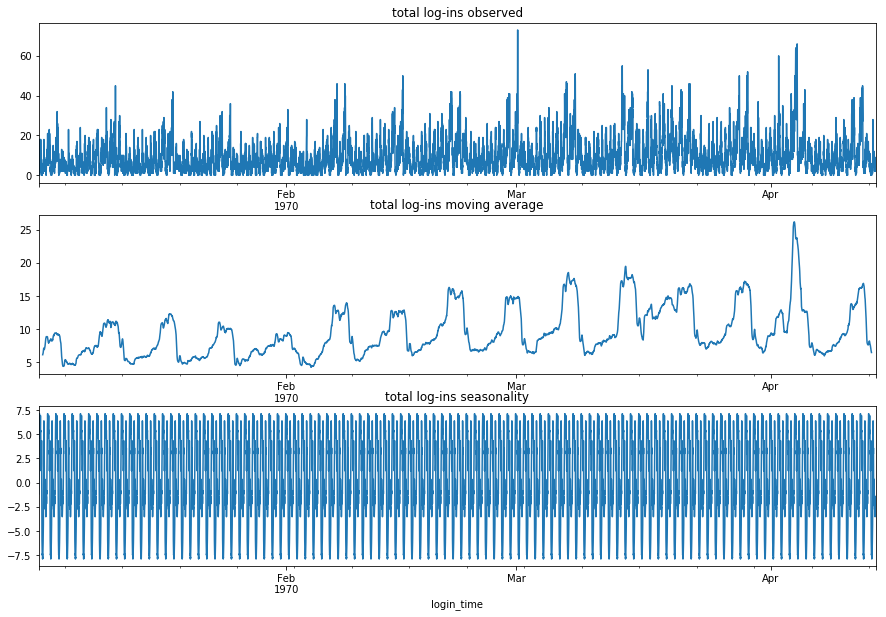

In [12]:
from statsmodels.tsa import seasonal
plt.figure(figsize=(15,10))

#decompose series and plot
r = sm.tsa.seasonal.seasonal_decompose(df_15.login, model='additive', freq=96)
plt.subplot(3,1,1)
r.observed.plot()
plt.title('total log-ins observed')
plt.subplot(3,1,2)
r.trend.plot()
plt.title('total log-ins moving average')
plt.subplot(3,1,3)
r.seasonal.plot()
plt.title('total log-ins seasonality')

So clearly there is a pattern to the logins over time, but the data as displayed here is hardly interpretable. What is immediately apparent is that there is a weekly trend to the login patters, and that the trend has become exhaggerated upwards over time. In other words, total logins are increasing over all. To get a closer look, check the daily and weekly patterns of logins by taking the mean across each over time.

In [19]:
#average each reading by hour of day across all days
daily = df_15.login.groupby(df_15.index.hour).mean()

#average each reading by day of week across all weeks
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'] #a list to reindex days as days of week
weekly = df_15.login.groupby(df_15.index.weekday_name).mean().reindex(days)

Text(0.5,1,'average total log-ins by day of week')

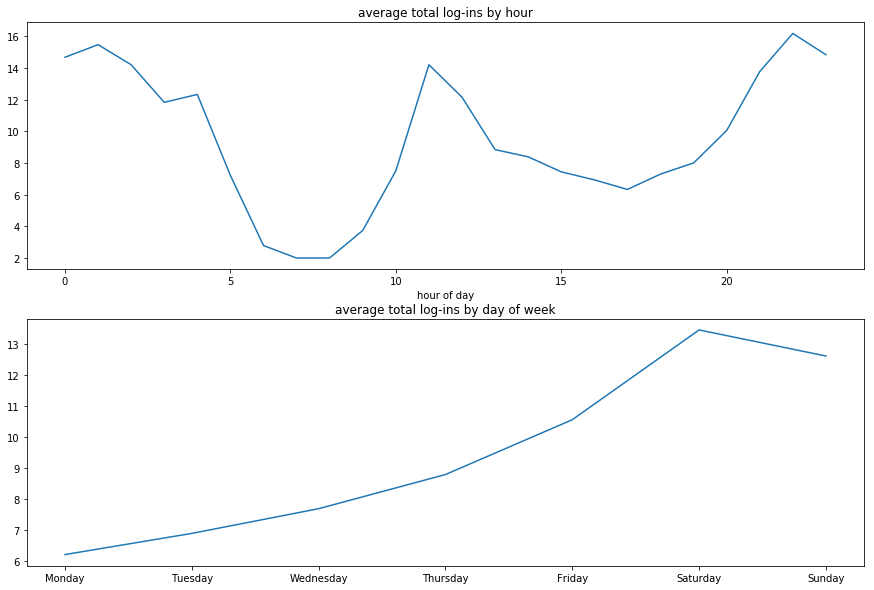

In [20]:
#plot
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.plot(daily)
plt.title('average total log-ins by hour')
plt.xlabel('hour of day')
plt.subplot(2,1,2)
plt.plot(weekly.values)
plt.xticks([0,1,2,3,4,5,6], days)
plt.title('average total log-ins by day of week')

Here it is apparent that peak activity for logins is between midnight and 4am, 10am to 12pm with a lull in the afternoon and study rise into the evening beginning at 5pm with another peak at 10pm. During the week, activity is lowest at Monday and rises steadily to peak on Saturday, with a slight decline on Sunday and a sharp drop off back on Monday.